# Give Me Some Credit

Modification using WOE transform and classifying using simple neural network.

The bad rate is about 6.77% (good 93.23%). Data preprocessing for ML model is using some transformer (toad dt) to binned the features values. The ROC AUC is a little bit (2%) better than the majority classifier in previous jupyter notebook. Nevertheless, it should be noted that even with unbalance dataset, this model could perform well without any resampling.

NN performance ==> acc:	 0.938, f1:	 0.251, AUC:	 0.851

<img src="./images/ROC_AUC_new.png" alt="Drawing" style="width: 500px;"/>

## Importing libraries and data

In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


import tensorflow as tf
#tf.debugging.set_log_device_placement(True)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import toad
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, f1_score,make_scorer, roc_auc_score, log_loss, roc_curve, roc_auc_score

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion

   

2023-08-05 20:07:21.448384: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#importing training data to pandas dataframe

df=pd.read_csv('cs-training.csv')
#dftest=pd.read_csv('cs-test.csv')

df.fillna(df.mean(),inplace=True)
#dftest.fillna(df.mean(),inplace=True)

print(df.shape)
#print(dftest.shape)
df

(150000, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.000000,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.000000,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.000000,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.000000,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.000000,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.000000,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.000000,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,6670.221237,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.000000,4,0,0,0,0.0


In [6]:
df.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

Split the data

(100000, 10)
(50000, 10)
(100000,)
(50000,)


(array([93371.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  6629.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

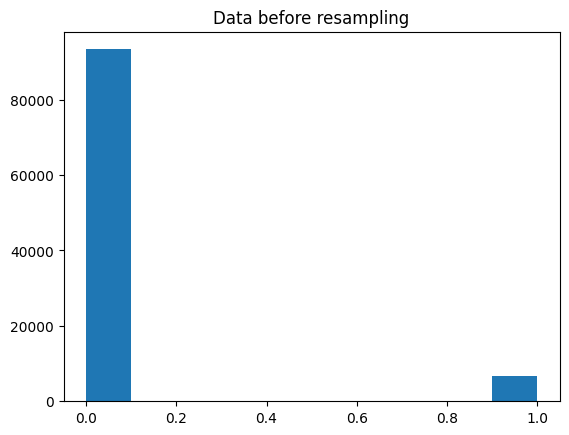

In [3]:
X=pd.get_dummies(df.drop(['Unnamed: 0','SeriousDlqin2yrs'],axis=1))
#X['Total Charges']=df['Total Charges'].astype(float)
y=df['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=1/3)


#X_train=df.iloc[:,2:]
#X_test=dftest.iloc[:,2:]
#y_train=df['SeriousDlqin2yrs']
#y_test=dftest['SeriousDlqin2yrs']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

plt.title('Data before resampling')
plt.hist(y_train)
#plt.savefig('images/data_beforeresample_dist.png', dpi=300)

In [86]:
#bad rate
bad=(y_train==1).sum()/len(y_train)*100
print("bad %.2f" % bad)
print("good %.2f" % (100-bad))

bad 6.77
good 93.23


In [61]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std=scaler.transform(X_train)
X_test_std=scaler.transform(X_test)

## Model building neural network

### Model data without WOE transform

In [52]:
%%time
model=Sequential()
model.add(Dense(units=64, activation='relu', input_dim=len(X_train.columns))) #hidden layer, 32 neuron
model.add(Dense(units=128, activation='relu')) #hidden layer
model.add(Dense(units=1, activation='sigmoid')) #output, yes or no

CPU times: user 46 ms, sys: 0 ns, total: 46 ms
Wall time: 46.4 ms


In [53]:
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics='accuracy')

In [80]:
%%time
model.fit(X_train_std.astype(np.float32), y_train.values.astype(np.float32),epochs=10, batch_size=16)

Epoch 1/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.2095 - accuracy: 0.9331
Epoch 2/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1948 - accuracy: 0.9349
Epoch 3/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1922 - accuracy: 0.9354
Epoch 4/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1909 - accuracy: 0.9357
Epoch 5/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1900 - accuracy: 0.9356
Epoch 6/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1895 - accuracy: 0.9358
Epoch 7/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1889 - accuracy: 0.9359
Epoch 8/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1886 - accuracy: 0.9361
Epoch 9/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1884 - accuracy: 0.9359
Epoch 10/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.188

In [65]:
X_train_std.shape

(100000, 10)

## Prediction no WOE

In [62]:
y_hat_prob=model.predict(X_test_std)
y_hat=[0 if val<0.5 else 1 for val in y_hat_prob]

In [97]:
print('acc:\t %.3f' % accuracy_score(y_test, y_hat))
f1=f1_score(y_test, y_hat)
print('f1:\t %.3f' % f1)
auc = roc_auc_score(y_test, y_hat_prob)
print('AUC:\t %.3f' % auc)

acc:	 0.938
f1:	 0.251
AUC:	 0.851


[[46391   348]
 [ 2744   517]]


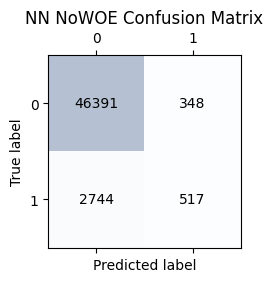

In [92]:
# DRAW CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_hat)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('NN NoWOE Confusion Matrix')
#plt.savefig('images/confusion_matrix_dt_nn_noWOE.png', dpi=300)
plt.show()

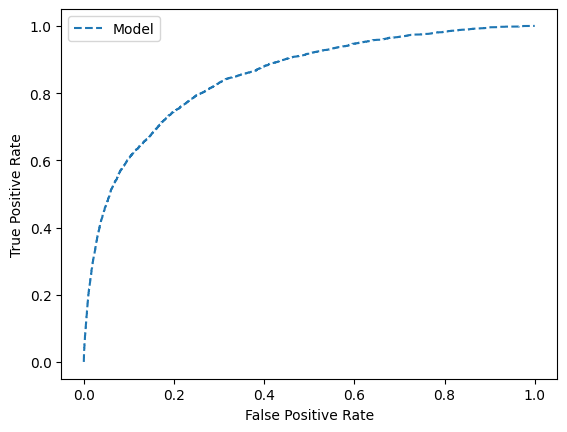

In [93]:
from matplotlib import pyplot
fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, linestyle='--', label='Model')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

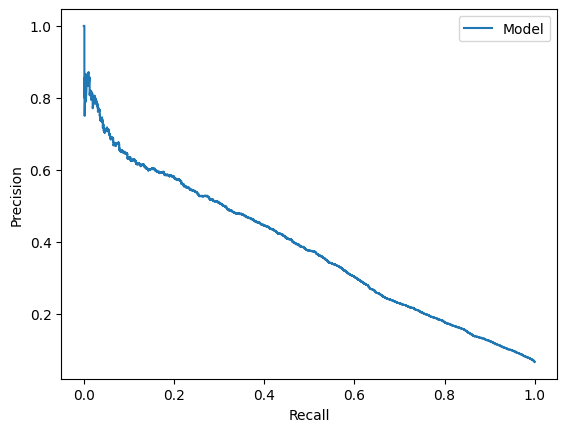

In [94]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_hat_prob)

# plot the precision-recall curves
pyplot.plot(recall, precision, marker='', label='Model')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Model data with Binning transform

#### Binning

In [33]:
%%time
data_tr = pd.concat([X_train,y_train],axis=1)
#data_tr['type'] = 'train' # A new feature to indicate test/training sample
data_ts = pd.concat([X_test,y_test],axis=1)
#data_ts['type'] = 'test'

# automatic binning and WOE transformation
c = toad.transform.Combiner()
c.fit(data_tr,y='SeriousDlqin2yrs',method='dt',min_samples =  0.05)

CPU times: user 374 ms, sys: 3.95 ms, total: 378 ms
Wall time: 378 ms


In [34]:
%%time
data_tr_bin=c.fit_transform(data_tr,data_tr['SeriousDlqin2yrs'], exclude=['SeriousDlqin2yrs'])
data_ts_bin=c.transform(data_ts)

CPU times: user 1min 59s, sys: 208 ms, total: 1min 59s
Wall time: 1min 59s


### Model data with binning

In [70]:
data_tr_bin

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
9614,5,4,0,7,3,7,0,2,0,4,0
110553,5,1,0,7,4,5,0,1,0,0,0
144423,3,6,0,4,9,7,0,1,0,0,0
49825,6,2,0,5,2,7,0,2,0,4,0
67101,5,5,0,5,2,5,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6310,5,2,0,2,8,4,0,0,0,5,0
104700,9,0,0,5,1,5,0,0,0,5,0
42700,7,8,3,4,1,4,0,0,0,0,1
144693,0,9,0,9,6,3,0,2,0,0,0


In [35]:
%%time
model=Sequential()
model.add(Dense(units=64, activation='relu', input_dim=len(data_tr_bin.drop(['SeriousDlqin2yrs'],axis=1).columns))) #hidden layer, 32 neuron
model.add(Dense(units=128, activation='relu')) #hidden layer
model.add(Dense(units=1, activation='sigmoid')) #output, yes or no

CPU times: user 184 ms, sys: 12 ms, total: 196 ms
Wall time: 232 ms


2023-08-05 20:20:39.915672: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-08-05 20:20:39.938074: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-08-05 20:20:39.938110: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: peach
2023-08-05 20:20:39.938120: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: peach
2023-08-05 20:20:39.938229: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.106.0
2023-08-05 20:20:39.938258: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.106.0
2023-08-05 20:20:39.938266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.106.0
2023-08-05 20:20:39.939526: I tensorflow/core/platform/cpu_feature_guard.cc:142] This Tensor

In [36]:
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics='accuracy')

In [37]:
%%time
model.fit(data_tr_bin.drop(['SeriousDlqin2yrs'],axis=1).values.astype(np.float32), 
          data_tr_bin['SeriousDlqin2yrs'].values.astype(np.float32),
          epochs=10, batch_size=16)

Epoch 1/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.2024 - accuracy: 0.9357
Epoch 2/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1891 - accuracy: 0.9370
Epoch 3/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1853 - accuracy: 0.9370
Epoch 4/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1833 - accuracy: 0.9371
Epoch 5/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.1820 - accuracy: 0.9369
Epoch 6/10
6250/6250 [==============================] - 8s 1ms/step - loss: 0.1808 - accuracy: 0.9371
Epoch 7/10
6250/6250 [==============================] - 16s 3ms/step - loss: 0.1804 - accuracy: 0.9375
Epoch 8/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.1802 - accuracy: 0.9372
Epoch 9/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.1798 - accuracy: 0.9376
Epoch 10/10
6250/6250 [==============================] - 7s 1ms/step - loss: 0.17

## Prediction with binning

In [38]:
y_hat_prob=model.predict(data_ts_bin.drop(['SeriousDlqin2yrs'],axis=1))
y_hat=[0 if val<0.5 else 1 for val in y_hat_prob]

y_hat_train_prob=model.predict(data_tr_bin.drop(['SeriousDlqin2yrs'],axis=1))
y_hat_train=[0 if val<0.5 else 1 for val in y_hat_train_prob]

In [39]:
y_test=data_ts_bin['SeriousDlqin2yrs']
print('acc:\t %.3f' % accuracy_score(y_test, y_hat))
f1=f1_score(y_test, y_hat)
print('f1:\t %.3f' % f1)
auc = roc_auc_score(y_test, y_hat_prob)
print('AUC:\t %.3f' % auc)

acc:	 0.935
f1:	 0.378
AUC:	 0.863


[[45794   809]
 [ 2418   979]]


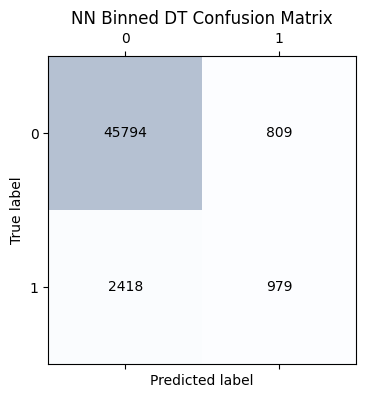

In [40]:
# DRAW CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_hat)
print(confmat)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('NN Binned DT Confusion Matrix')
#plt.savefig('images/confusion_matrix_dt_nn_bin1.png', dpi=300)
plt.show()

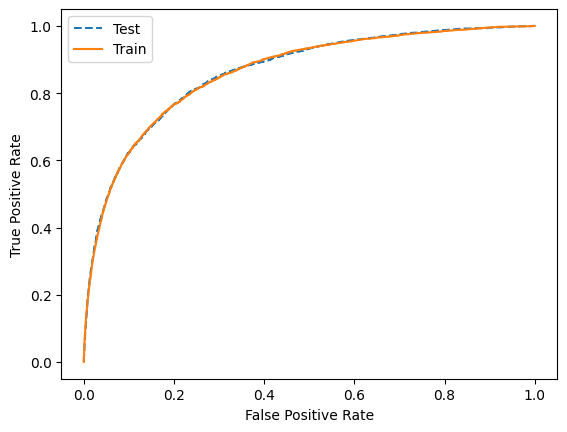

In [41]:
from matplotlib import pyplot
fpr, tpr, thresholds = roc_curve(y_test, y_hat_prob)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, linestyle='--', label='Test')

fpr, tpr, thresholds = roc_curve(y_train, y_hat_train_prob)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, linestyle='-', label='Train')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig('images/ROC_AUC_NN_bin.png', dpi=300)

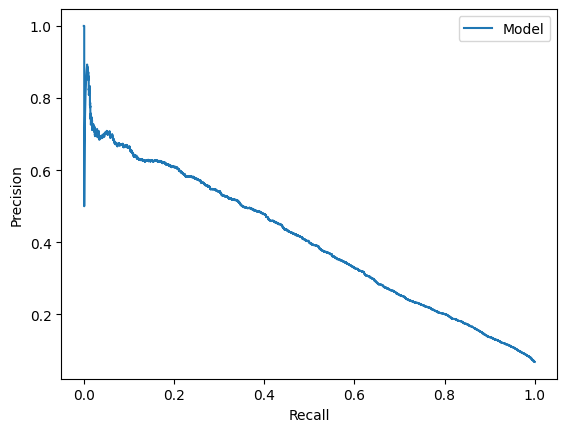

In [42]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_hat_prob)

# plot the precision-recall curves
pyplot.plot(recall, precision, marker='', label='Model')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig('images/prec_recall_NN_bin.png', dpi=300)

## Save model

In [43]:
model.save('tf_givemesomecredit_bin_dt.keras')

## LGBM

In [7]:
import lightgbm as lgb

In [17]:
clf = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
clf.fit(data_tr_bin.drop(['SeriousDlqin2yrs'],axis=1).values.astype(np.float32),y_train)

[LightGBM] [Info] Number of positive: 6629, number of negative: 93371
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066290 -> initscore=-2.645127
[LightGBM] [Info] Start training from score -2.645127


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [18]:
y_hat_lgb_prob = clf.predict(X_test)
y_hat_lgb=[0 if val<0.5 else 1 for val in y_hat_lgb_prob]

In [26]:
y_test=data_ts_bin['SeriousDlqin2yrs']
print('acc:\t %.3f' % accuracy_score(y_test, y_hat_lgb_prob))
f1=f1_score(y_test, y_hat_lgb_prob)
print('f1:\t %.3f' % f1)
auc = roc_auc_score(y_test, y_hat_lgb_prob)
print('AUC:\t %.3f' % auc)

acc:	 0.934
f1:	 0.139
AUC:	 0.537


[[46438   165]
 [ 3131   266]]


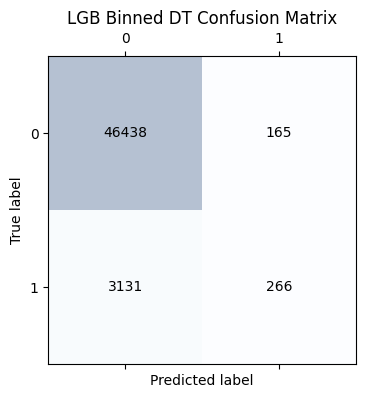

In [27]:
# DRAW CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_hat_lgb_prob)
print(confmat)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('LGB Binned DT Confusion Matrix')
plt.savefig('images/confusion_matrix_dt_lgb_bin.png', dpi=300)
plt.show()

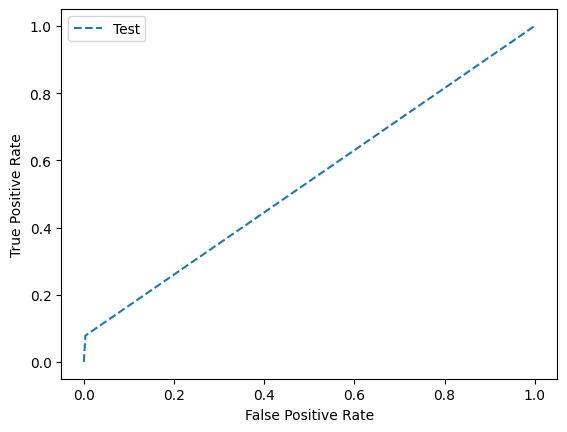

In [28]:
from matplotlib import pyplot
fpr, tpr, thresholds = roc_curve(y_test, y_hat_lgb_prob)
# plot the roc curve for the model
pyplot.plot(fpr, tpr, linestyle='--', label='Test')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig('images/ROC_AUC_lgb.png', dpi=300)

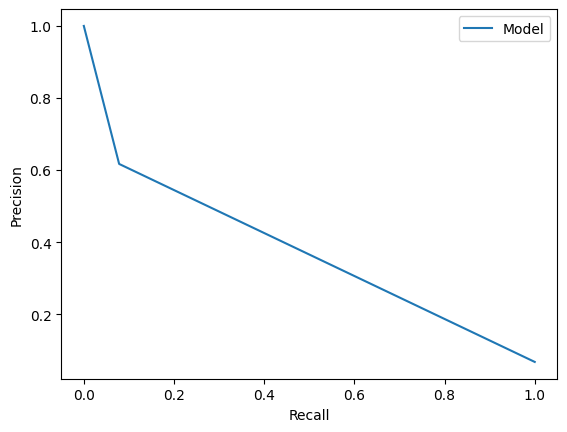

In [29]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_hat_lgb_prob)

# plot the precision-recall curves
pyplot.plot(recall, precision, marker='', label='Model')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.savefig('images/prec_recall_lgb.png', dpi=300)

## Past result from classifier2.ipynb

In [15]:
'''
Classifier2 result
ROC AUC: 0.77 (+/- 0.00418) [Logistic regression]
ROC AUC: 0.75 (+/- 0.00615) [Decision tree]
ROC AUC: 0.78 (+/- 0.00497) [SVC]
ROC AUC: 0.84 (+/- 0.00827) [Majority voting]
'''    

'\nClassifier2 result\nROC AUC: 0.77 (+/- 0.00418) [Logistic regression]\nROC AUC: 0.75 (+/- 0.00615) [Decision tree]\nROC AUC: 0.78 (+/- 0.00497) [SVC]\nROC AUC: 0.84 (+/- 0.00827) [Majority voting]\n'

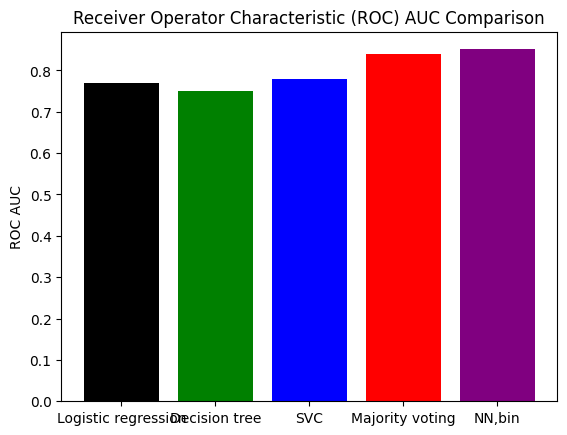

In [82]:
roc_label=['Logistic regression','Decision tree','SVC','Majority voting','NN,bin']
roc_val=[.77,.75,.78,.84,0.851]

plt.ylabel('ROC AUC')
plt.bar(roc_label,height=roc_val,color=['black','green','blue','red','purple'])

plt.title('Receiver Operator Characteristic (ROC) AUC Comparison')
plt.savefig('images/ROC_AUC_new.png', dpi=300)

In [83]:
(0.851-0.84)/.84

0.013095238095238108